In [15]:
import warnings
warnings.filterwarnings('ignore')

<div style="border: 2px solid #00008B; padding: 15px; border-radius: 10px; background-color: #00008B; color: #FFFFFF; font-family: Arial;">
  <h1 style="margin-top: 0;">Classificação de casos de Alzheimer</h1>

A escala clínica usada para avaliar o estágio de gravidade da demência em pacientes: demência muito leve, demência leve, demência moderada, além de sem demência

Baseado em: https://www.kaggle.com/code/danttis/alzheimer-s-classification-using-knn/notebook

</div>

<div style="background-color: #f0f8ff; padding: 20px; border-radius: 10px;">
  <ul>
    <li>ID (identificação)</li> 
    <li>Sexo (M/F)</li> 
    <li>Mão dominante (Hand)</li> 
    <li>Idade (Age)</li> 
    <li>Nível de educação (Edu)</li> 
    <li>Status socioeconômico (SES)</li> 
    <li>Pontuação no Mini-Mental State Examination (MMSE) que avalia a função cognitiva</li> 
    <li>Classificação do Clinical Dementia Rating (CDR) que indica o estágio de gravidade da demência</li> 
    <li>Volume total do cérebro e do crânio (eTIV)</li> 
    <li>Volume Cerebral Total Normalizado (nWBV) que mede o volume cerebral relativo ao tamanho total do cérebro</li> 
    <li>Valor único do tamanho relativo do cérebro em relação a um atlas padrão (ASF)</li> 
    <li>Atraso (Delay), medido em meses, entre a aquisição das imagens cerebrais e a avaliação clínica ou cognitiva dos participantes</li>
  </ul>
</div>

# Gerando dados fictícios

In [34]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

In [17]:
data = {
    'ID': range(1, 21),
    'Sexo': ['M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F', 'M', 'F'],
    'Mão Dominante': ['D', 'E', 'D', 'D', 'E', 'D', 'E', 'D', 'D', 'E', 'D', 'D', 'E', 'D', 'E', 'D', 'D', 'E', 'D', 'D'],
    'Idade': [75, 80, 65, 70, 85, 60, 77, 82, 67, 72, 88, 62, 74, 68, 81, 73, 66, 78, 79, 64],
    'Nível de Educação': [12, 16, 14, 10, 18, 13, 15, 12, 16, 11, 17, 14, 13, 15, 11, 12, 13, 14, 15, 16],
    'Status Socioeconômico': [3, 4, 2, 1, 5, 3, 4, 2, 1, 5, 3, 4, 2, 1, 5, 3, 4, 2, 1, 5],
    'MMSE': [25, 30, 40, 24, 28, 26, 31, 39, 23, 29, 27, 32, 38, 22, 28, 24, 31, 37, 21, 26],
    'CDR': ['DML', 'SD', 'DML', 'DL', 'DML', 'DL', 'SD', 'DL', 'DML', 'DML', 'DL', 'SD', 'DML', 'DL', 'DML', 'DML', 'DL', 'SD', 'DML', 'DML'],
    'eTIV': [1500, 1600, 1950, 1480, 1570, 1500, 1600, 1950, 1480, 1570, 1500, 1600, 1950, 1480, 1570, 1500, 1600, 1950, 1480, 1570],
    'nWBV': [0.68, 0.70, 0.86, 0.65, 0.69, 0.68, 0.70, 0.86, 0.65, 0.69, 0.68, 0.70, 0.86, 0.65, 0.69, 0.68, 0.70, 0.86, 0.65, 0.69],
    'ASF': [1.2, 1.1, 1.9, 1.2, 1.1, 1.2, 1.1, 1.9, 1.2, 1.1, 1.2, 1.1, 1.9, 1.2, 1.1, 1.2, 1.1, 1.9, 1.2, 1.1],
    'Delay': [0, 2, 1, 3, 4, 0, 2, 1, 3, 4, 0, 2, 1, 3, 4, 0, 2, 1, 3, 4]
}

df = pd.DataFrame(data)
df.head()

,ID,Sexo,Mão Dominante,Idade,Nível de Educação,Status Socioeconômico,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,1,M,D,75,12,3,25,DML,1500,0.68,1.2,0
1,2,F,E,80,16,4,30,SD,1600,0.70,1.1,2
2,3,M,D,65,14,2,40,DML,1950,0.86,1.9,1
3,4,F,D,70,10,1,24,DL,1480,0.65,1.2,3
4,5,M,E,85,18,5,28,DML,1570,0.69,1.1,4


# Preparando os dados

In [18]:
# Convertendo Sexo e Mão Dominante para códigos numéricos
df['Sexo'] = df['Sexo'].astype('category').cat.codes
df['Mão Dominante'] = df['Mão Dominante'].astype('category').cat.codes

X = df[['Sexo','Mão Dominante', 'Idade', 'Nível de Educação', 'Status Socioeconômico', 'MMSE', 'eTIV', 'nWBV', 'ASF', 'Delay']]
y = df['CDR']

# Dividindo os dados em treino e teste

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Supervisionado

### KNN Classifier

In [30]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)

In [31]:
# Calculando a acurácia do KNN
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("Acurácia do KNN:", knn_accuracy)

Acurácia do KNN: 0.25


In [21]:
novo_dado = np.array([[1, 1, 70, 16, 4, 28, 1600, 0.70, 1.2, 2]])

# Fazendo a previsão
nova_previsao = knn.predict(novo_dado)
print("Previsão para o novo exemplo:", nova_previsao)

Previsão para o novo exemplo: ['SD']


### Decision Tree Classifier

In [32]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
tree_predictions = tree.predict(X_test)

In [33]:
# Calculando a acurácia da árvore de decisão
tree_accuracy = accuracy_score(y_test, tree_predictions)
print("Acurácia da Árvore de Decisão:", tree_accuracy)

Acurácia da Árvore de Decisão: 0.25


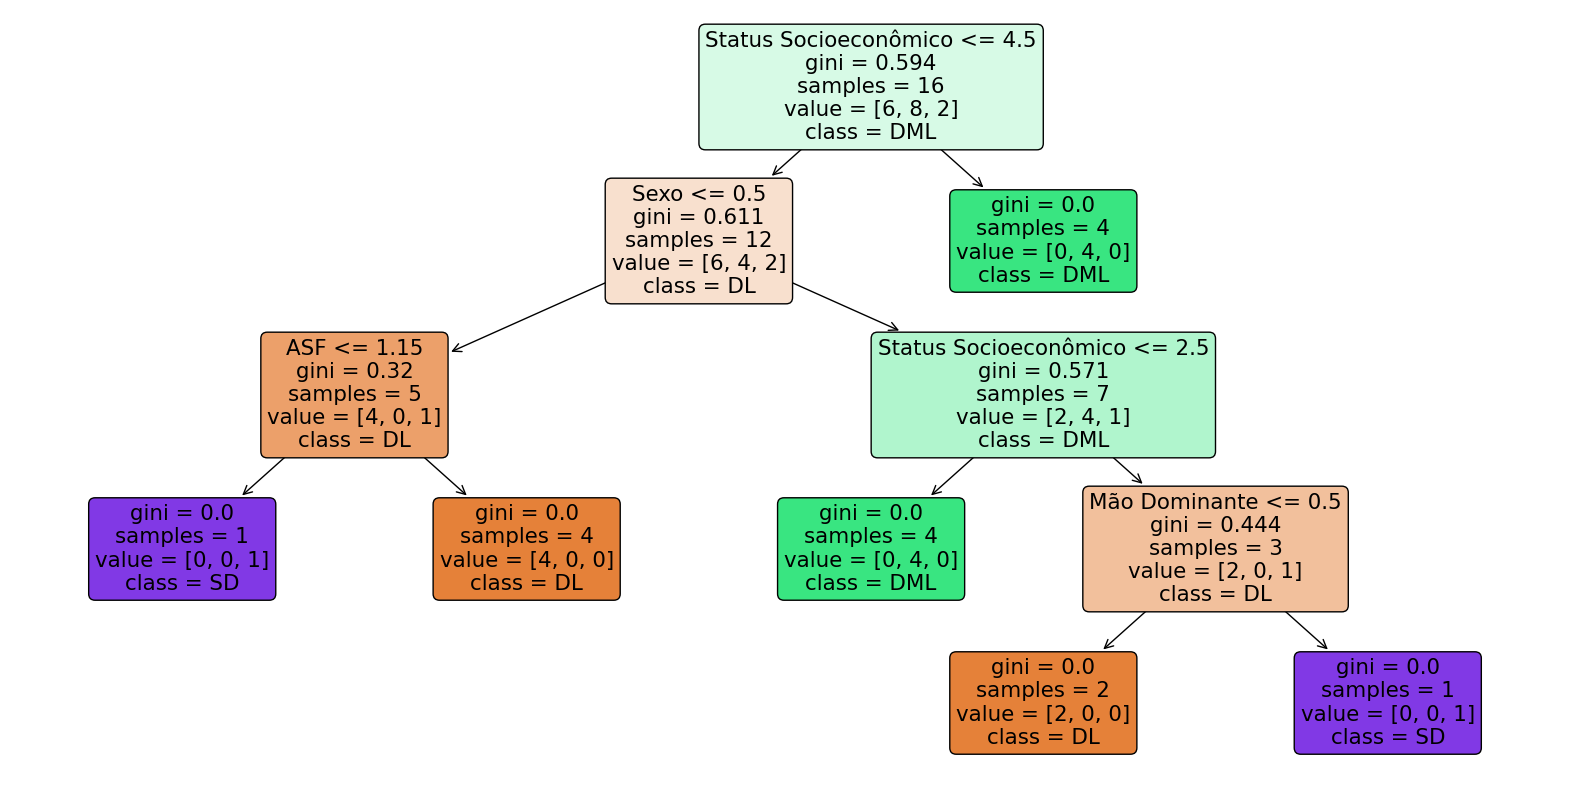

In [23]:
# Visualizando a árvore de decisão
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=X.columns, class_names=tree.classes_, filled=True, rounded=True)
plt.show()

In [24]:
novo_dado = np.array([[1, 1, 70, 16, 4, 28, 1600, 0.70, 1.2, 2]])

# Fazendo a previsão
nova_previsao = tree.predict(novo_dado)
print("Previsão para o novo exemplo:", nova_previsao)

Previsão para o novo exemplo: ['SD']


# Não Supervisionado

### KMeans Clustering

In [35]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)
clusters = kmeans.predict(X)

Como KMeans é um algoritmo de clustering, você não pode usar diretamente a métrica de acurácia, pois não há rótulos verdadeiros para comparar. No entanto, você pode avaliar a qualidade dos clusters usando métricas como o Silhouette Score ou Davies-Bouldin Score.

In [37]:
# Calculando o Silhouette Score
kmeans_silhouette = silhouette_score(X, clusters)
print("Silhouette Score do KMeans:", kmeans_silhouette)

Silhouette Score do KMeans: 0.7507379156425191


In [26]:
novo_dado = np.array([[1, 1, 70, 16, 4, 28, 1600, 0.70, 1.2, 2]])

# Fazendo a previsão
nova_previsao = kmeans.predict(novo_dado)
print("Previsão para o novo exemplo:", nova_previsao)

Previsão para o novo exemplo: [3]


In [27]:
# Adicionando a coluna CDR_cluster ao dataframe
df['CDR_cluster'] = clusters
df.head()

,ID,Sexo,Mão Dominante,Idade,Nível de Educação,Status Socioeconômico,MMSE,CDR,eTIV,nWBV,ASF,Delay,CDR_cluster
0,1,1,0,75,12,3,25,DML,1500,0.68,1.2,0,2
1,2,0,1,80,16,4,30,SD,1600,0.70,1.1,2,3
2,3,1,0,65,14,2,40,DML,1950,0.86,1.9,1,0
3,4,0,0,70,10,1,24,DL,1480,0.65,1.2,3,2
4,5,1,1,85,18,5,28,DML,1570,0.69,1.1,4,1


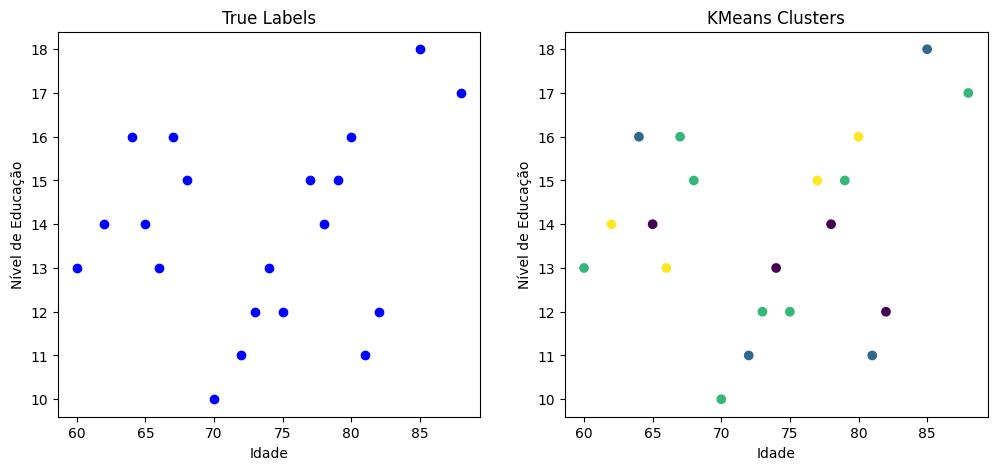

In [28]:
# Visualizando os resultados
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X['Idade'], X['Nível de Educação'], c='blue', label='True Labels')
plt.title('True Labels')
plt.xlabel('Idade')
plt.ylabel('Nível de Educação')

plt.subplot(1, 2, 2)
plt.scatter(X['Idade'], X['Nível de Educação'], c=clusters, cmap='viridis', label='KMeans Clusters')
plt.title('KMeans Clusters')
plt.xlabel('Idade')
plt.ylabel('Nível de Educação')

plt.show()